# Athena and the Genetic Algorithm
## Using the genetic algorithm to search for and interpret an accurate model

In this tutorial we will demonstrate Athena's searching capabilities using the genetic algorithm. Similar to previous tutorials, we will create a simple interpretable model for surface temperature; however, this time we will increase our input dimensionality to also include parameters such as, but not limited to, light intensity and wind speed. 

To ensure the created model is as interpretable as possible, during the creation and heuristic search, we will list each "constituent" of our "Additive Model" along with each constituent's "contribution". Here we define a constituent contribution as the percentage of the output that this constituent contributes (on average).

This methodology allows the interpreter of a generated Athena model to see how much "weight" each "contribution" has on the final model output. This in turn gives confidence in the model and its interpretation.

In [ ]:
from pandas import read_csv, DataFrame
import numpy as np
from athena.helpers import *
from athena.framework import Framework
from athena.dataset import Dataset
from athena.searching import RandomSearch
from sympy import init_printing, Symbol, lambdify, N

In [1]:
df = read_csv('testing_data.csv', index_col=None)
df = df[['time', 'UV', 'baromin', 'humidity', 'light', 'rainin', 'temp', 'windgust']]

In [ ]:
from dateutil.parser import parse

def get_hour (x):
    y = parse(x)
    return y.hour + y.minute / 60.0

df["time"] = [get_hour(x) / 24.0 for x in df["time"].values]

In [ ]:
parameters_map = {
    "normalized"    : {
        "humidity": "rh",
        "windgust": "ws",
        "UV"      : "uv",
        "light"   : "light",
    },
    "not_normalized": {
        "time"  : "time",
        "rainin": "rain",
    },
    "target"        : "temp",
}

In [ ]:
inverse_parameters_map = {}

for l in ["normalized", "not_normalized"]:
    for i, j in parameters_map[l].items():
        inverse_parameters_map[j] = i

In [ ]:
framework_parameters = {
    "starting_lr"   : 0.01,
    "max_iterations": int(1e4),
    "momentum"      : 0.99,
}

fw = Framework(framework_parameters)

In [ ]:
init_printing()

In [ ]:
training_df, testing_df = split_dataframe(df, 0.9)
fw.add_dataset(Dataset(training_df, testing_df, parameters_map))
target_values = df[fw.dataset.target_column_name].values

In [2]:
reconstruction_list = None
search_length = 100
equation_length = 1

In [3]:
for iteration in range(10):
    rs = RandomSearch(fw, search_length=search_length, 
                      equation_length=equation_length,
                      starting_equations=reconstruction_list)

    print("=" * 40, iteration + 1, "=" * 40)
    rs.search(return_constituents=True)
    equation = rs.get_best_equations(k=1)[0]
    
    print("\n" * 2)
    
    print("Correlation:", str(int(round(equation["testing_pearson"] * 100)))+"%")

    biases, equations = 0, []
    for i, cnst in enumerate(equation["equation"]):
        if len(cnst.atoms(Symbol)) == 0:
            biases += cnst
        else:
            equations += [cnst]

    equation["equation"] = [biases] + equations

    print("\n" * 2)
    print(sum(equation["equation"]))
    print("\n" * 2)

    contributions = []
    interval_ranges = []

    eq_df = []

    for i, cnst in enumerate(equation["equation"]):
        variables = cnst.atoms(Symbol)

        substitutions = [df[inverse_parameters_map[str(v)]].values for v in variables]
        function = lambdify(tuple(variables), cnst, "numpy")
        contribution = mean_confidence_interval(np.abs(function(*tuple(substitutions))) / target_values * 100.0, 0.99)

        eq_df.append({"Constituent": str(N(cnst,1)),
                      "Contribution": int(round(contribution[0]))})

    eq_df = DataFrame(data=eq_df)
    print(eq_df)


    reconstruction_list = equation["reconstruction"]

  0%|          | 0/100 [00:00<?, ?it/s]

======================================== 1 ========================================


100%|██████████| 100/100 [06:11<00:00,  3.71s/it]





Correlation: 78%



-2.23423337936401*sin(1.78139195803401*pi*sin(0.914900183677673*pi*time + 0.372391581535339) - 1.73457026481628) + 16.446117401123



                                         Constituent  Contribution
0                                              2.e+1            77
1  -2.0*sin(1.78139195803401*pi*sin(0.91490018367...             6
======================================== 2 ========================================


100%|██████████| 100/100 [09:22<00:00,  5.63s/it]





Correlation: 83%



-9.07721424102783*sin(0.329096466302872*pi*(0.0121413603958864*rh - 0.178579171963195) + 5.41522407531738) + 5.72021293640137*sin(0.000507846327916825*pi*sin(0.779995977878571*pi*time + 0.334638386964798) + 1.58176827430725) + 5.80316066741943



                                         Constituent  Contribution
0                                                 6.            27
1  6.0*sin(0.000507846327916825*pi*sin(0.77999597...            27
2  -9.0*sin(0.329096466302872*pi*(0.0121413603958...            15
======================================== 3 ========================================


100%|██████████| 100/100 [11:42<00:00,  7.03s/it]





Correlation: 87%



-6.87950754165649*sin(0.438953667879105*pi*(0.0121413603958864*rh - 0.178579171963195) + 4.86050319671631) + 6.76584482192993*sin(3.53402824313395*pi*sin(0.119170002639294*pi*time - 4.45090246200562) - 2.51338601112366) - 3.73639559745789*sin(4.56242515062632*pi*sin(0.399930357933044*pi*time + 0.718033134937286) + 3.83703780174255) + 3.83102226257324



                                         Constituent  Contribution
0                                                 4.            18
1  -4.0*sin(4.56242515062632*pi*sin(0.39993035793...            14
2  -7.0*sin(0.438953667879105*pi*(0.0121413603958...            21
3  7.0*sin(3.53402824313395*pi*sin(0.119170002639...            25
======================================== 4 ========================================


100%|██████████| 100/100 [16:12<00:00,  7.23s/it]





Correlation: 87%



-8.64439010620117*sin(0.431226015090942*pi*(0.0121413603958864*rh - 0.178579171963195) + 4.66944313049316) + 5.83411979675293*sin(0.482983041439756*pi*sin(1.76392769813538*pi*time - 1.51666712760925) + 2.12311744689941) + 6.59114789962769*sin(0.192457450653725*pi*sin(2.4000563621521*pi*time + 0.818538010120392) + 2.43383240699768) + 5.77661657333374*sin(0.801900991253689*pi*sin(0.640102505683899*pi*(0.0121413603958864*rh - 0.178579171963195) + 0.73687332868576) - 0.167653933167458) + 2.8070969581604



                                         Constituent  Contribution
0                                                 3.            13
1  7.0*sin(0.192457450653725*pi*sin(2.40005636215...            15
2  -9.0*sin(0.431226015090942*pi*(0.0121413603958...            31
3  6.0*sin(0.482983041439756*pi*sin(1.76392769813...            17
4  6.0*sin(0.801900991253689*pi*sin(0.64010250568...            23
======================================== 5 ========================

100%|██████████| 100/100 [22:21<00:00,  8.81s/it]





Correlation: 88%



-0.108704280377071*((0.000207868513421424*uv - 1.32522150605615)**2)**6.86443758010864 - 6.64442682266235*sin(0.942916750907898*pi*(0.0121413603958864*rh - 0.178579171963195) + 3.87507319450378) - 4.5134801864624*sin(0.69813492379188*pi*sin(1.04224634170532*pi*time + 0.187580764293671) - 1.32605266571045) + 2.09778046607971*sin(0.583842832190754*pi*sin(2.0566771030426*pi*time - 1.56739640235901) + 0.41304412484169) + 2.82000780105591*sin(0.000241248432461748*pi*sin(2.00982856750488*pi*(0.0121413603958864*rh - 0.178579171963195) + 5.44569778442383) + 1.56405603885651) + 16.6117350556269



                                         Constituent  Contribution
0                                                 3.            12
1  -5.0*sin(0.69813492379188*pi*sin(1.04224634170...            12
2  -7.0*sin(0.942916750907898*pi*(0.0121413603958...            21
3  2.0*sin(0.583842832190754*pi*sin(2.05667710304...             8
4  3.0*sin(0.000241248432461748*pi*sin(2.00982

100%|██████████| 100/100 [36:42<00:00, 12.53s/it]




Correlation: 88%



-106.320375743941*((0.000207868513421424*uv - 0.585832742151575)**2)**2.85807800292969 - 6.68328332901001*sin(0.910211026668549*pi*(0.0121413603958864*rh - 0.178579171963195) + 3.91286945343018) - 3.94568133354187*sin(1.51351125961639*pi*sin(0.712405383586884*pi*time + 0.606210947036743) + 2.46521353721619) + 2.44976997375488*sin(0.494462707224315*pi*sin(2.14040231704712*pi*time + 1.47456800937653) + 2.31827902793884) - 0.186561062932014*sin(1.73729971038112*pi*sin(2.04860401153564*pi*(0.0121413603958864*rh - 0.178579171963195) - 0.894892394542694) - 2.00623106956482) + 20.2357221101399



                                         Constituent  Contribution
0                                                 3.            12
1  2.0*sin(0.494462707224315*pi*sin(2.14040231704...             7
2  -7.0*sin(0.910211026668549*pi*(0.0121413603958...            21
3  -4.0*sin(1.51351125961639*pi*sin(0.71240538358...            11
4  -0.2*sin(1.73729971038112*pi*sin(2.0486040

100%|██████████| 100/100 [36:37<00:00, 18.15s/it]





Correlation: 88%



-72.5906688544369*((0.000207868513421424*uv - 0.653047111925439)**2)**2.94515526294708 - 1.06220698356628*sin(2.36428570747375*pi*(0.0121413603958864*rh - 0.178579171963195) - 1.99269270896912) - 0.351880133152008*sin(2.7104012966156*pi*(0.000207868513421424*uv - 0.000207868513421424) - 1.69783985614777) - 0.398926377296448*sin(1.6011873479185*pi*sin(1.66841149330139*pi*time + 2.28416228294373) + 0.953392028808594) + 4.33806037902832*sin(0.201250949815483*pi*sin(2.07353448867798*pi*time - 2.02475762367249) + 1.3360276222229) - 3.49679160118103*sin(0.665840965755493*pi*sin(0.643418788909912*pi*(0.0121413603958864*rh - 0.178579171963195) + 1.32890450954437) - 3.0117974281311) + 16.0545992498376



                                         Constituent  Contribution
0                                                 2.            12
1  -0.4*sin(1.6011873479185*pi*sin(1.668411493301...             1
2  -1.0*sin(2.36428570747375*pi*(0.01214136039588...             3
3  4

100%|██████████| 100/100 [39:51<00:00, 19.18s/it]





Correlation: 88%



-0.752889591943934*((0.000207868513421424*uv - 1.5053008469909)**2)**2.97212159633636 + 2.87016250398097*exp(0.0144869640245666*rh) + 7.49391841888428*sin(0.681115508079529*pi*(0.0121413603958864*rh - 0.178579171963195) + 1.67976629734039) + 0.635002851486206*sin(2.76208519935608*pi*(0.000207868513421424*uv - 0.000207868513421424) + 0.487185508012772) - 2.32810187339783*sin(4.03652320974572*pi*sin(0.168915957212448*pi*time - 0.426510870456696) - 0.607482850551605) - 0.494413793087006*sin(1.16913175476198*pi*sin(2.18774724006653*pi*time + 2.52062773704529) + 2.36507272720337) + 5.39676952362061*sin(1.63119310920627*pi*sin(0.448808342218399*pi*(0.0121413603958864*rh - 0.178579171963195) + 4.19940567016602) - 0.394325464963913) + 4.06066118371877



                                         Constituent  Contribution
0                                                 4.            19
1  -0.5*sin(1.16913175476198*pi*sin(2.18774724006...             1
2  8.0*sin(0.681115

100%|██████████| 100/100 [40:40<00:00, 17.25s/it]





Correlation: 88%



1.71963683613413*((0.000207868513421424*uv + 2.61623075872962)**2)**0.535921186208725 - 1.16995334625244*sin(2.26793789863586*pi*(0.0121413603958864*rh - 0.178579171963195) + 4.34339570999146) + 3.65445446968079*sin(1.05030047893524*pi*(0.000207868513421424*uv - 0.000207868513421424) + 0.954768300056458) - 0.857295274734497*sin(3.64913633940159*pi*sin(0.685444951057434*pi*time - 2.85340714454651) + 0.697910130023956) - 2.81372404098511*sin(0.376303013228672*pi*sin(1.72479128837585*pi*time + 1.77890598773956) + 0.383417516946793) + 5.54653215408325*sin(1.40955976394906*pi*sin(0.370048135519028*pi*(0.0121413603958864*rh - 0.178579171963195) - 1.67308008670807) - 0.473306685686111) + 1.82829679151518 + 0.829903423786163*exp(-0.953741385438304*ws) - 0.211028283966341*exp(-0.000657708047018407*rh)



                                         Constituent  Contribution
0                                                0.4             2
1  -0.9*sin(3.64913633940159*pi*sin(

100%|██████████| 100/100 [41:18<00:00, 16.57s/it] 





Correlation: 88%



2.44445246377928*((0.000207868513421424*uv + 1.85477534205024)**2)**0.56717723608017 - 0.702971450362601*exp(0.0162054209462343*rh) + 2.45856785774231*sin(0.58031439781189*pi*(0.0121413603958864*rh - 0.178579171963195) + 1.72014093399048) + 5.62312459945679*sin(1.50941014289856*pi*(0.000207868513421424*uv - 0.000207868513421424) + 0.167697668075562) + 2.23206400871277*sin(2.48030242068396*pi*(0.000207868513421424*uv + 0.216657894554778) - 0.180877283215523) + 1.46588551998138*sin(1.81080356240123*pi*sin(0.695584893226624*pi*time + 0.300657600164413) + 1.61446022987366) - 2.31263160705566*sin(0.10676316673582*pi*sin(5.99593305587769*pi*time - 4.24081707000732) - 1.48941791057587) + 2.43571186065674*sin(0.901889626714592*pi*sin(0.765421211719513*pi*(0.0121413603958864*rh - 0.178579171963195) + 0.585990309715271) - 0.0793533399701118) - 2.05193851346337 + 0.867446899414063*exp(-0.741180255980428*ws)



                                         Constituent  Contributi

## Constituent Contribution vs. Model Growth

Bonus: we can also graph each constituent contribution against "time of model growth" (which in our case is the genetic algorithm generation). The y-axis here represents the contribution as a percentage of the output, on average. Each item in the legend identifies the corresponding constituent as function of a parameter; for the case of compositive functions, they are identified in order of composition (eg: SimplePolynomial Exponential UV).

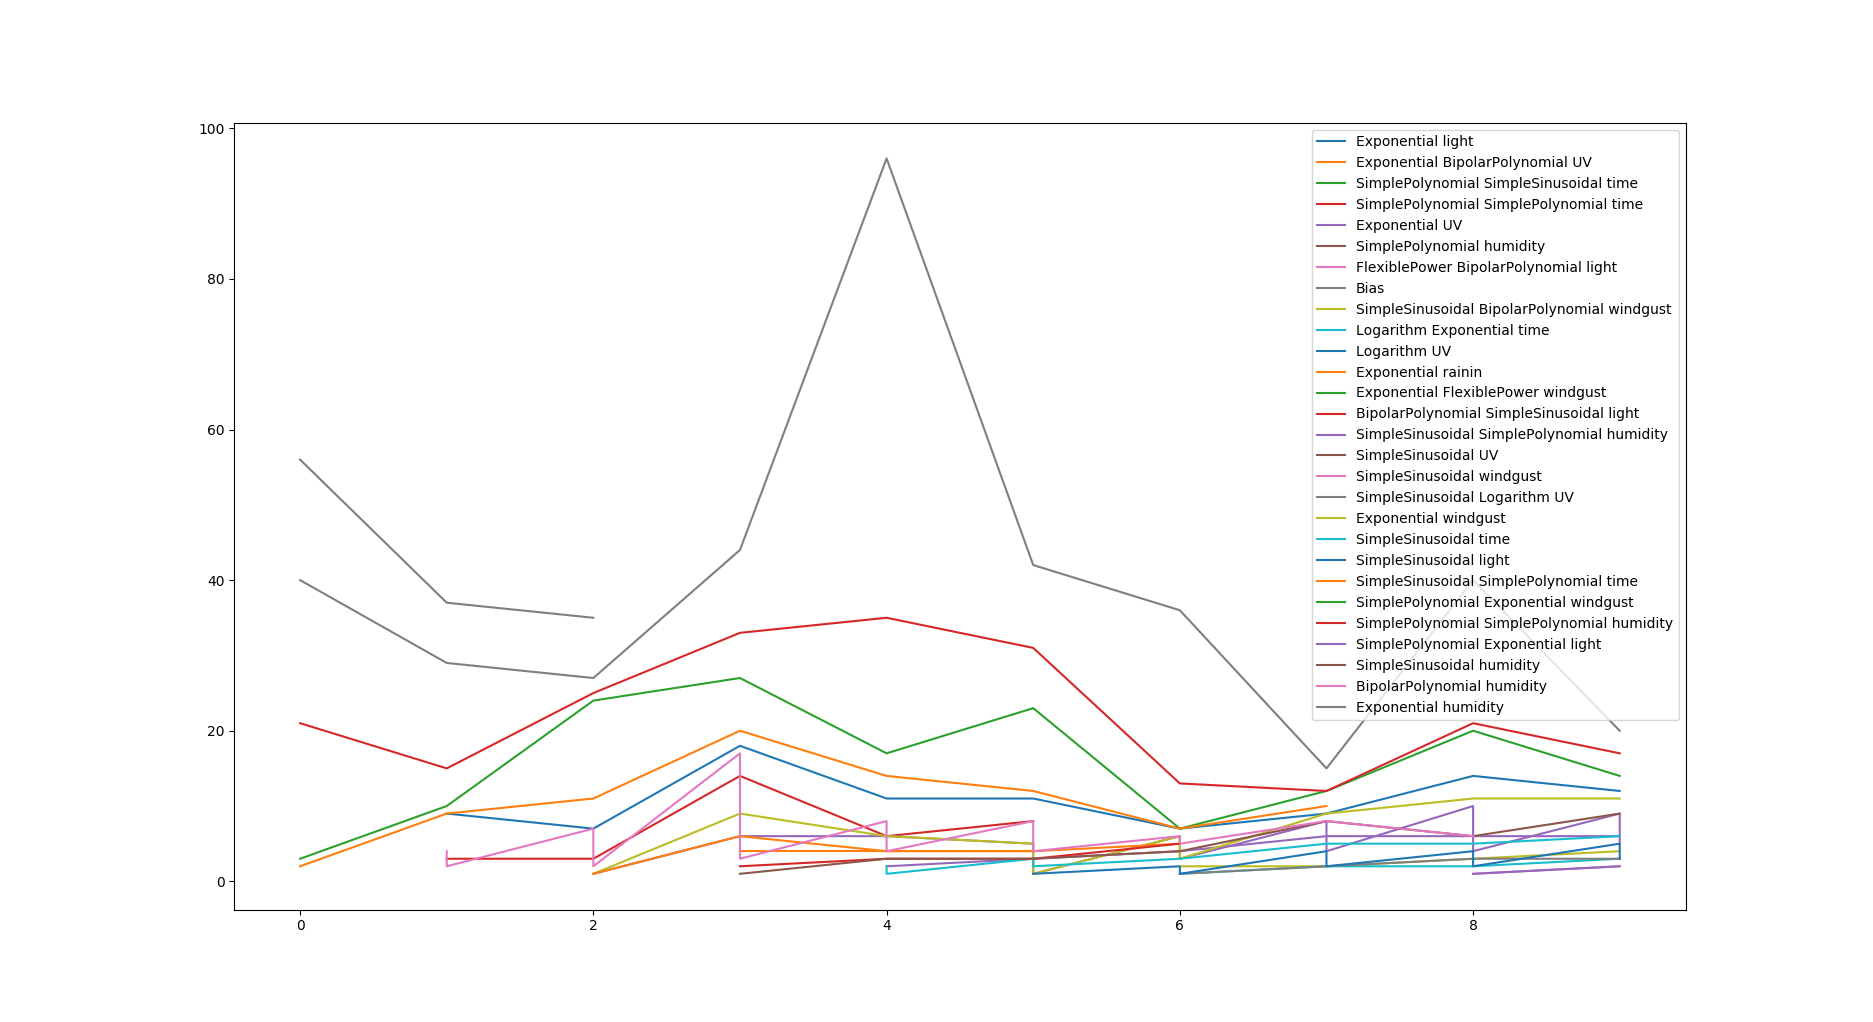

In [7]:
from IPython.display import Image 
Image(filename="/home/khaled/Documents/figure_1.png")